# Predicting the Gasoline Consumption of Cars

In this notebook, we'll carry out exploratory analysis followed by modelling on gasoline consumption dataset(Data set from Neter, Kutner, Nachtsheim, & Wasserman).

An automobile manufacturer studied the effects of differences between drivers (Driver) and cars (Car) on gasoline consumption. 4 drivers and 5 cars of the same model were part of the experiment. Each driver drove each car twice over a 40 mile test course and the miles per gallon (MPG) were recorded.

The dataset contains 4 variables:
1. MPG
2. Driver
3. Car
4. Replicate

Importing the dataset:

In [1]:
#install.packages("readxl")
library(readxl)
mpg3 <- read_excel("C:/Users/91879/OneDrive/Documents/mpg3.xlsx")

Examining the data types of the variables:

In [2]:
lapply(mpg3,class)

$MPG
[1] "numeric"

$Driver
[1] "numeric"

$Car
[1] "numeric"

$Replicate
[1] "numeric"

The variables Driver and Car have to be converted into factor variables.

In [3]:
mpg3$Driver = factor(mpg3$Driver)
mpg3$Car = factor(mpg3$Car)
summary(mpg3$Car)
summary(mpg3$Driver)

1 2 3 4 5 
8 8 8 8 8

1  2  3  4 
10 10 10 10

Checking the head of the dataframe:

In [4]:
head(mpg3)

MPG,Driver,Car,Replicate
<dbl>,<fct>,<fct>,<dbl>
25.3,1,1,1
25.2,1,1,2
28.9,1,2,1
30.0,1,2,2
24.8,1,3,1
25.1,1,3,2


## Exploratory Analysis 

Let's start by checking how the mpg is distributed by plotting an Histogram.

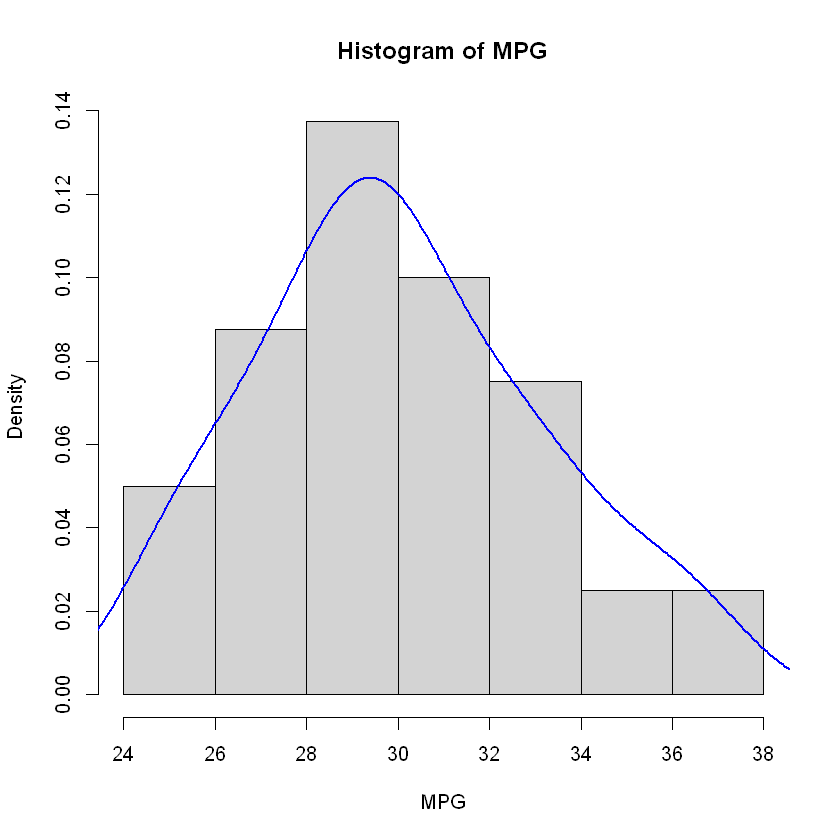

In [5]:
attach(mpg3)
hist(MPG,prob = TRUE,xlab = "MPG",main = "Histogram of MPG")
lines(density(MPG), col="blue", lwd=2)

The above histogram suggests that the MPG is Normally distributed.Let's validate this observation using a Quantile-quantile plot with theoretical quantiles of Normal distribution.

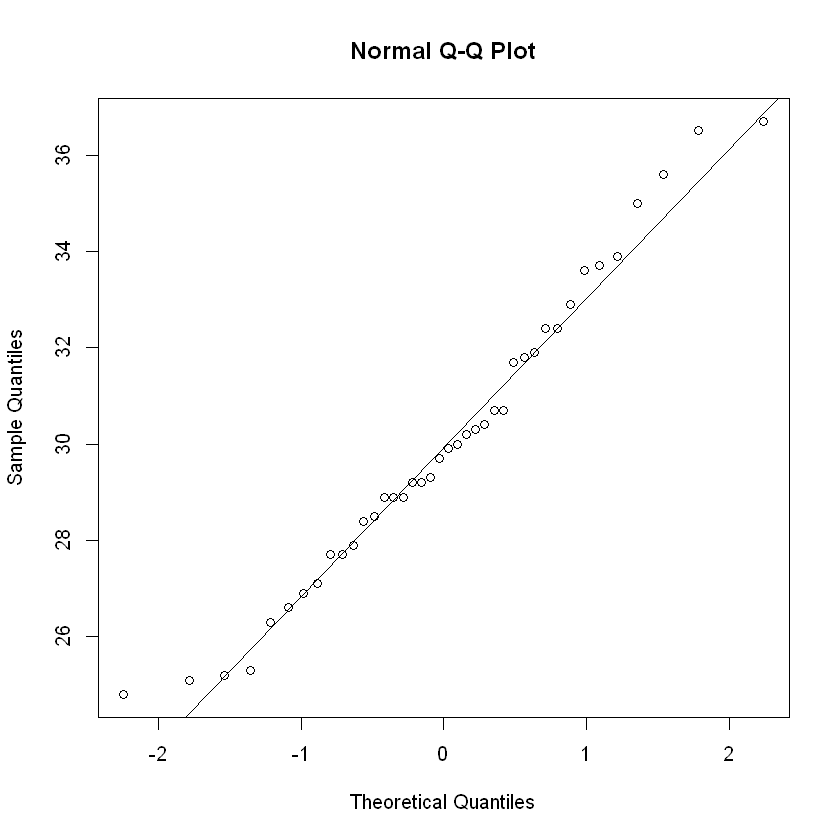

In [6]:
qqnorm(MPG)
qqline(MPG, distribution = qnorm)

The overall pattern of the Q-Q plot is approximately linear indicating that the MPG is Normally distributed. This can be supported by Kolmogorov-Smirnov goodness of fit test(ks test).

Firstly, a Normal distribution is to be fitted to the MPG by Maximum-Likelihood method and the parameters are estimated(MLE). The KS test is performed between MPG and the data simulated from Normal distribution with estimated parameters(MLE).

In [7]:
library(MASS)
fit = fitdistr(MPG,"normal")
ks.test(MPG,rnorm(1000,fit$estimate[1],fit$estimate[2]))

Warning message in ks.test(MPG, rnorm(1000, fit$estimate[1], fit$estimate[2])):
"p-value will be approximate in the presence of ties"



	Two-sample Kolmogorov-Smirnov test

data:  MPG and rnorm(1000, fit$estimate[1], fit$estimate[2])
D = 0.109, p-value = 0.7507
alternative hypothesis: two-sided


The Null hypothesis of the KS test is that both the samples are drawn from the same distribution. The p-value >> 0.05 implies that the null hypothesis shouldn't be rejected and concludes the Normal distribution of MPG.

Now let's compare the gasoline consumption of the 4 drivers.

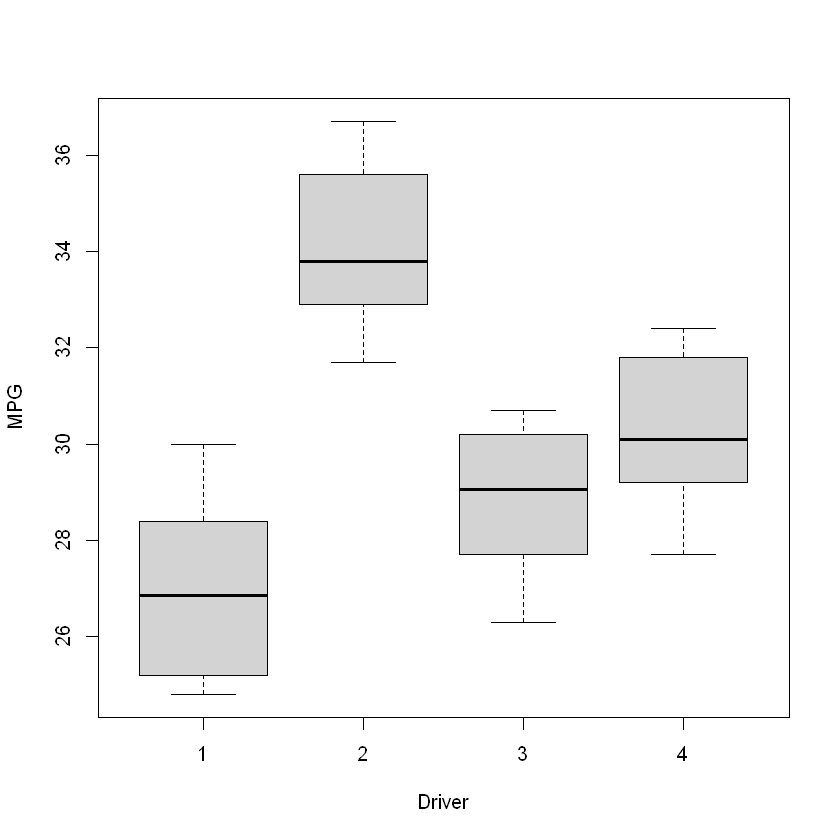

In [8]:
boxplot(MPG ~ Driver,ylab = 'MPG')

The above plot is a boxplot of MPG against drivers. The Gasoline consumption of driver-2 seems to be significantly higher than the other drivers. ANOVA test ($null hypothesis : \mu_{1}=\mu_{2}=\mu_{3}=\mu_{4}$) can be carried out to validate this observation.

In [9]:
anova(lm(MPG ~ Driver))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Driver,3,280.2848,93.428250,33.40866,1.671672e-10
Residuals,36,100.6750,2.796528,NA,NA


The p-value of $1.672\times10^{−10}$ suggests that there is a significant difference in gasoline consumption for atleast two drivers.

Now let's compare the gasoline consumption of the 5 cars.

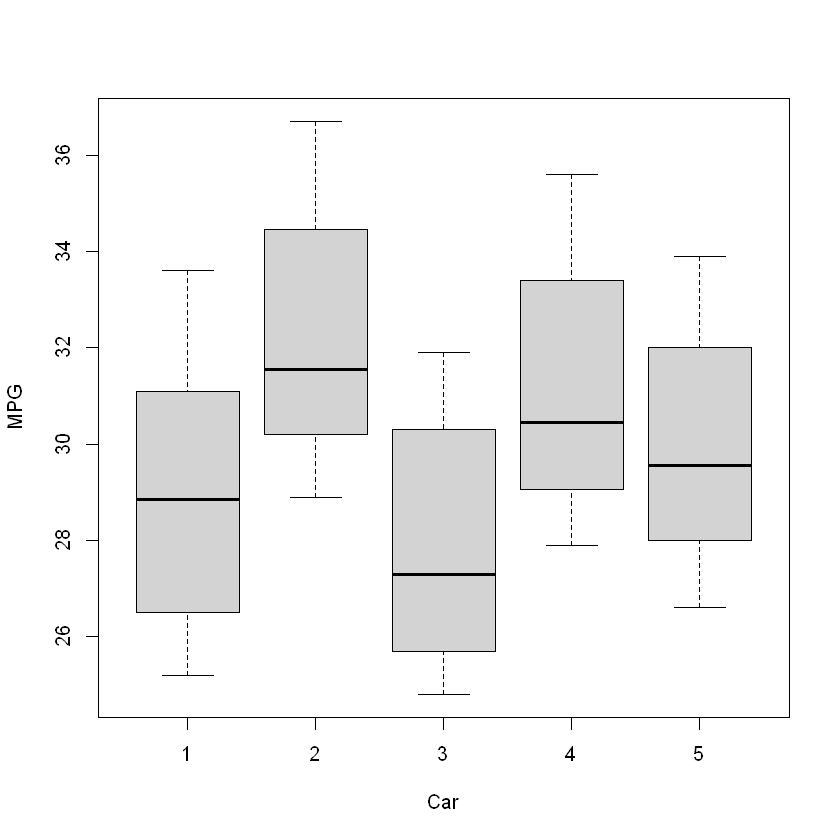

In [10]:
boxplot(MPG ~ Car,ylab = 'MPG')

The above plot is a boxplot of MPG against cars. It looks like there is a significant difference in gasoline consumption for different cars. ANOVA test ($null hypothesis : \mu_{1}=\mu_{2}=\mu_{3}=\mu_{4}=\mu_{5}$) can be carried out to validate this observation.

In [11]:
anova(lm(MPG ~ Car))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Car,4,94.7135,23.678375,2.89521,0.03597349
Residuals,35,286.2463,8.178464,NA,NA


The ANOVA test supports our observation with a p-value of 0.036.

Let's see if there is interaction between the two variables (cars and drivers). 

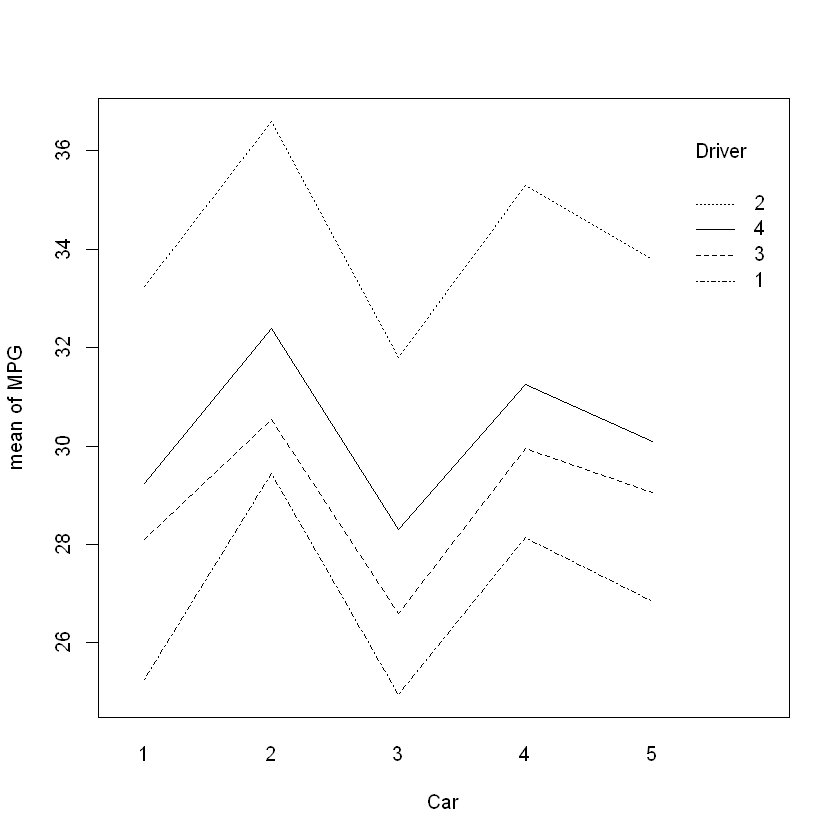

In [12]:
interaction.plot(Car,Driver,MPG,ylab = "mean of MPG")

The above plot is the interaction plot between drivers and cars. The MPG vs car plots for different drivers are parallel, this indicates that there is no interaction between the variables car and driver.

From the exploratory analysis, we have observed:
1. Gasoline consumption is normally distributed.
2. The variables Driver and Car have significant effect on the gasoline consumption.
3. There is no interaction between Driver and Car variables.

## Fixed Effects Model Fitting, Diagnostics and Evaluation 

### Fitting Fixed Effects Model 

A fixed effects model can be fitted if the objective of the study is limited to analysing just the 4 drivers and 5 cars or if there are pre-existing clusters corresponding to each level of the factor variables which exhaust the entire study population (Driver = 1 in data corresponds to a group of similar drivers and not a single driver). Let's assume one of them is the case and fit a fixed effects model.

From the conclusions of the exploratory analysis, it would be ideal to fit a Gaussian generalized linear model with linear link function (same estimates and results as OLS regression) and Cars, Drivers as fixed effects (model1).

As Gasoline consumption is always greater than 0, let's consider fitting a Gamma generalised linear model with log link function as it helps in restricting the predictions to realistic values (model2).

Fitting the 2 models mentioned above:

In [13]:
model1 = glm(MPG ~ Driver + Car, family = gaussian())
model2 = glm(MPG ~ Driver + Car, family = Gamma(link = "log"))

### Model Diagnostics 

Though we have fit the ideal models based on the exploratory analysis, the data themselves may indicate that a particular model is unsuitable. Thus, model diagnostics is an important precautionary step.

Diagnostics of the 3 models:
1. Informal check using deviance residuals: Standardized deviance residuals are plotted against the fitted values transformed to the constant-information scale of the error distribution.(2log($\hat{\mu}$) for gamma glm and $\hat{\mu}$ for normal glm(since the transformation is identity))

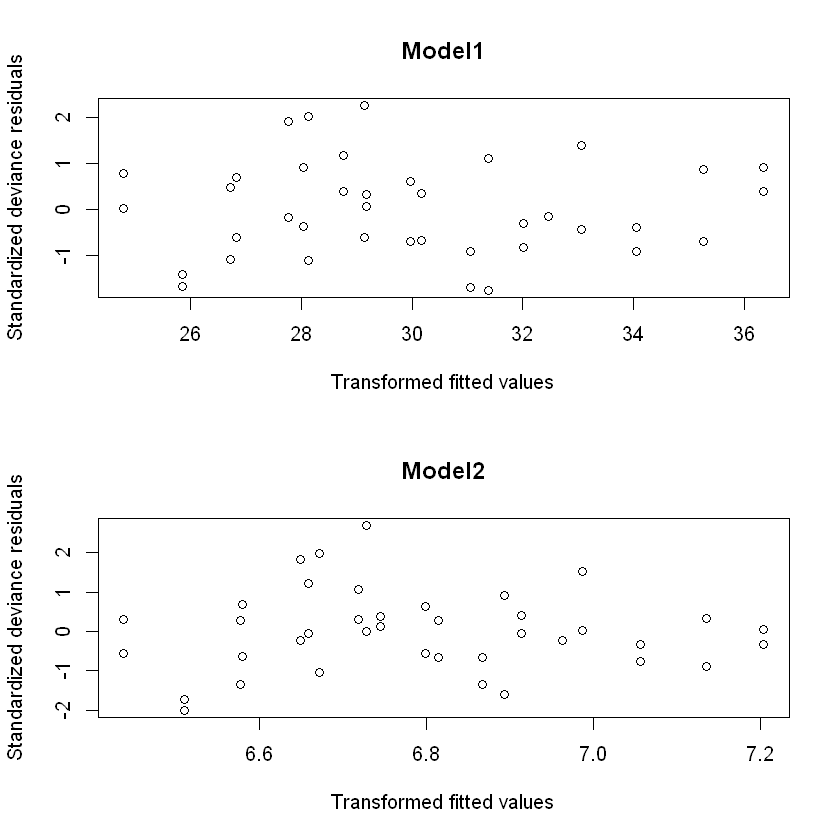

In [14]:
par(mfrow = c(2,1))
plot(fitted(model1),rstandard(model1,type = "deviance"),xlab = "Transformed fitted values",ylab = "Standardized deviance residuals",main = "Model1")
plot(2*log(fitted(model2)),rstandard(model2,type = "deviance"),xlab = "Transformed fitted values",ylab = "Standardized deviance residuals",main = "Model2")

The null pattern of this plot is a distribution of residuals for varying $\hat{\mu}$ with mean 0 and constant range. Both the models have a null pattern.

2. Checking the link function: A plot of the adjusted dependent variable $z_{i}=\hat{\eta}_{i}+(y_{i}-\hat{\mu}_{i})(\frac{\partial\eta_{i}}{\partial\mu_{i}})_{\beta=\hat{\beta}}$ against $\hat{\eta}_{i}$ gives an informal check on the link function.

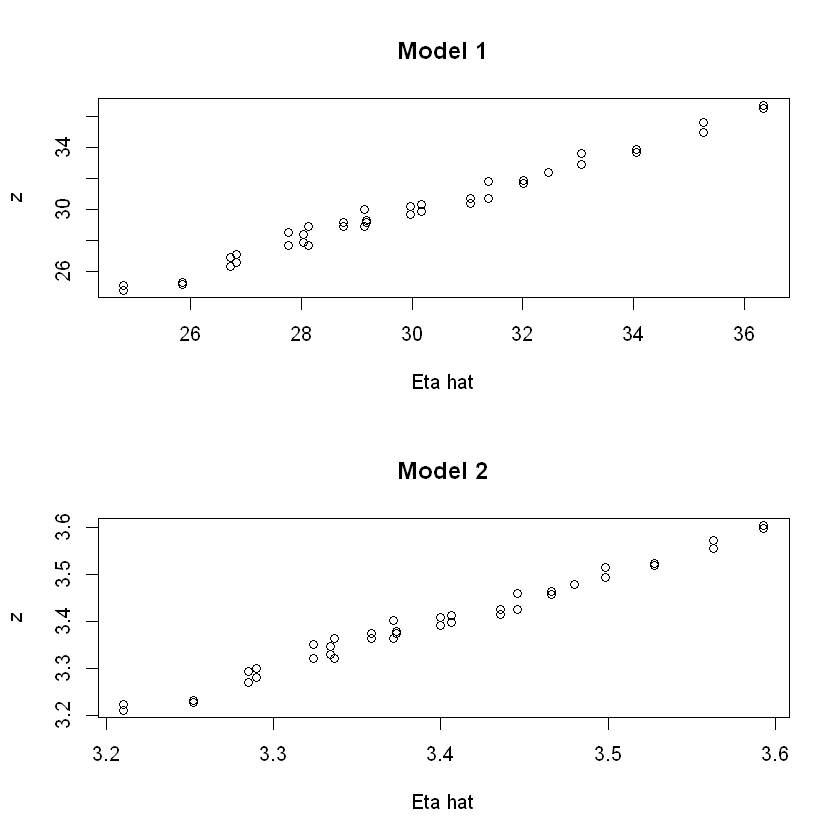

In [15]:
par(mfrow = c(2,1))
plot(fitted(model1), MPG, xlab = "Eta hat", ylab = "z", main = "Model 1")
plot(log(fitted(model1)),log(fitted(model1)) + (MPG-fitted(model1))/(fitted(model1)),xlab = "Eta hat",ylab = "z",main = "Model 2")

The null pattern of this plot is a straight line. Both the models do not have curvature and therefore have a null pattern indicating there are no concerns with link function.

3. Checking the model fit: A plot of actual and the fitted values of dependent variable against independent variable gives an informal check on the prediction accuracy and model fit.

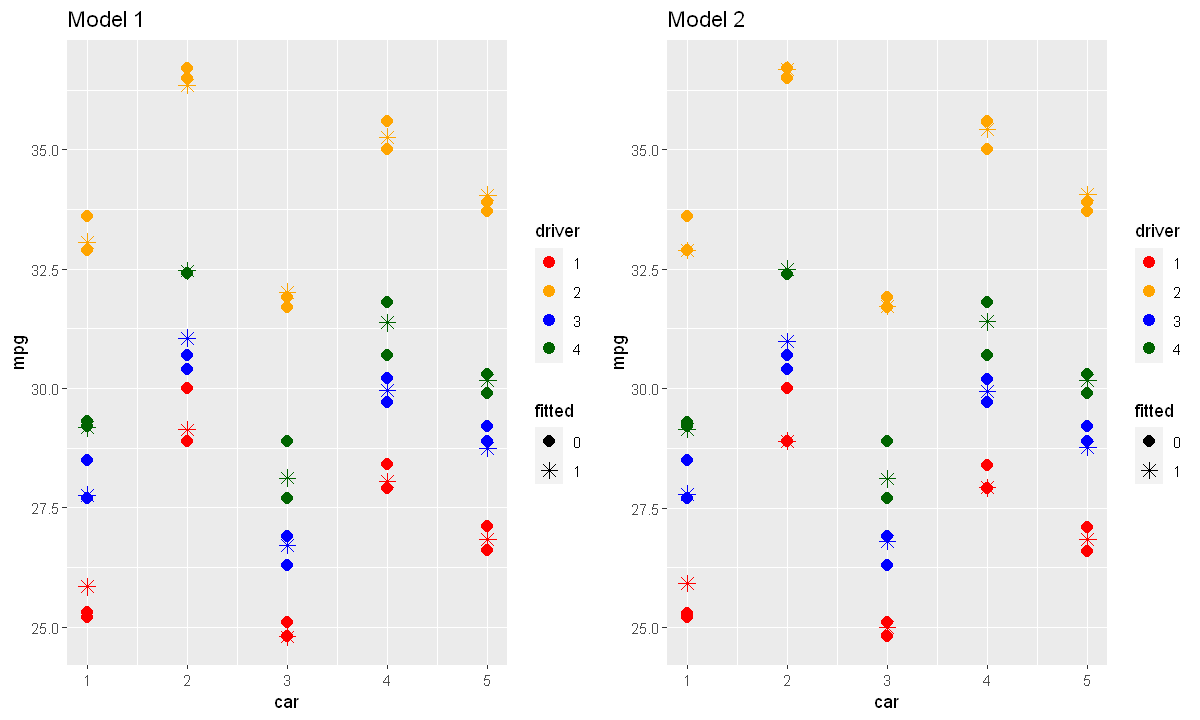

In [16]:
library(ggplot2)
library(gridExtra)
options(repr.plot.width=10,repr.plot.height=6)

mpg = c(MPG,fitted(model1))  
car = c(Car,Car)  
driver = c(Driver,Driver)
fitted = c(rep(0,40),rep(1,40))

df = data.frame(mpg,car,driver,fitted)

df$driver = factor(df$driver)
df$fitted = factor(df$fitted)

plot1 = ggplot(df, aes(x=car, y=mpg, color=driver, shape=fitted)) +
               geom_point(size = 3) + 
               scale_color_manual(values=c('red','orange','blue','darkgreen')) +
               scale_shape_manual(values=c(16,8)) +
               ggtitle("Model 1")

mpg = c(MPG,fitted(model2))

df = data.frame(mpg,car,driver,fitted)

df$driver = factor(df$driver)
df$fitted = factor(df$fitted)

plot2 = ggplot(df, aes(x=car, y=mpg, color=driver, shape=fitted)) +
               geom_point(size = 3) + 
               scale_color_manual(values=c('red','orange','blue','darkgreen')) +
               scale_shape_manual(values=c(16,8)) +
               ggtitle("Model 2")

grid.arrange(plot1,plot2,ncol = 2)

Both model1 and model2 seems to have an almost equal accuracy in predictions and raise no concerns.

Therefore, the model diagnostics conclude that there aren't any major issues or concerns for both the models.

### Model Evaluation 

The parameters in the generalized linear model are estimated using Maximum-Likelihood method. Unlike Gaussian glm, the Maximum-Likelihood estimates in generalized linear models aren't same as the OLS estimates. So, it's important to choose Maximum-Likelihood based evaluation metrics.

1. Akaike Information Criterion(AIC): It is an evaluation metric used to compare different possible models and determine which one is the best fit. According to AIC, the best fit model will be the one that neither under-fits nor over-fits. The best fitted model among a set of models is the one with least AIC.$$AIC=2k-2ln(\hat{L})$$where k = number of estimated parameters in the model and $\hat{L}$= maximum value of the likelihood function of the model.

2. Cox-Snell Pseudo-$R^{2}$: It is based on the log-likelihood of the model compared to the log-likelihood of a baseline model. According to pseudo-$R^{2}$, the best fit model will be the one that best predicts the observed values. The model with largest pseudo-$R^{2}$ is best fitted model according to this metric. However, this metric alone can be quite misleading as it doesn't account for the over-fitting.$$Cox-Snell R^{2}=1-(\frac{L_{0}}{L_{M}})^{\frac{2}{n}}$$where $L_{M}$= maximum value of the likelihood function of the model M and $L_{0}$= the value of likelihood function for a model with no predictors.

In [17]:
library(lmtest)
Model = c("Model1","Model2")
AIC = c(AIC(model1),AIC(model2))
CoxSnell_PseudoR2 = c(1-(exp(lrtest(model1)$LogLik[2])/exp(lrtest(model1)$LogLik[1]))^(2/nrow(mpg3)),
                      1-(exp(lrtest(model2)$LogLik[2])/exp(lrtest(model2)$LogLik[1]))^(2/nrow(mpg3)))
Modelevaluation = cbind(Model,AIC,CoxSnell_PseudoR2)
Modelevaluation

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




Model,AIC,CoxSnell_PseudoR2
Model1,55.3727895823784,0.984351365203279
Model2,61.5587996922697,0.981389906832883


Therefore, model1 is a slightly better fit compared to model2.

### Fitting Random Effects Model

“When a sample exhausts the population, the corresponding variable is fixed; when the sample is a small (i.e., negligible) part of the population the corresponding variable is random.” (Green and Tukey, 1960).

Suppose we have sampled out 5 cars and 4 drivers from a large population, then both the variables are random and it would be most appropriate to fit a random effects model.

As the model1 is more accurate compared to model2, we now fit a model with the same variance function, link function as model1 and with variables Car and Driver taken as random effects.

In [18]:
library(lme4)
REM = lmer(MPG ~ (1|Driver) + (1|Car),REML = F,data = mpg3)
summary(REM)

Loading required package: Matrix



Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: MPG ~ (1 | Driver) + (1 | Car)
   Data: mpg3

     AIC      BIC   logLik deviance df.resid 
    97.7    104.4    -44.8     89.7       36 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5411 -0.6018 -0.1011  0.6117  2.0342 

Random effects:
 Groups   Name        Variance Std.Dev.
 Car      (Intercept) 2.7744   1.6656  
 Driver   (Intercept) 7.4158   2.7232  
 Residual             0.1863   0.4316  
Number of obs: 40, groups:  Car, 5; Driver, 4

Fixed effects:
            Estimate Std. Error t value
(Intercept)   30.047      1.554   19.34

Therefore, the Population model is:$$E(MPG|Driver,Car)=30.048+N(0,1.6656)+N(0,2.7232)$$

In [19]:
library(lmerTest)
rand(REM)


Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step




,npar,logLik,AIC,LRT,Df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,4,-44.83636,97.67272,NA,NA,NA
(1 | Driver),3,-100.88741,207.77483,112.10211,1,3.393738e-26
(1 | Car),3,-83.76738,173.53476,77.86204,1,1.104947e-18


From the anova-like table for the random effects, p-value << 0.05 for both Driver and Car indicate that both the random effects are significant.

Considering a variable as a fixed or random effect should be dependent upon the study population and type of the variable to get an interpretable and meaningful result. 